# Block 1: Environment Setup & Imports

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

# Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2026-02-02 06:57:34.470084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770015454.664397      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770015454.720211      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770015455.210260      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770015455.210296      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770015455.210299      24 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Block 2: Data Loading & Preprocessing


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 10)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 10)


# Block 3: Data Augmentation Setup


In [3]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation/test
test_datagen = ImageDataGenerator()

# Create data generators
batch_size = 128
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

# Block 4: Residual Block Implementation


In [4]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None):
    """
    A residual block for ResNet-18/34 (Basic Block)
    
    Args:
        x: input tensor
        filters: number of filters
        kernel_size: kernel size for convolution
        stride: stride for first convolution
        conv_shortcut: use convolution for shortcut (True) or identity (False)
        name: block label
    """
    bn_axis = 3  # Channel axis for 'channels_last'
    
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, name=name + '_0_bn')(shortcut)
    else:
        shortcut = x
    
    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', 
                      use_bias=False, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)
    
    # Second convolution
    x = layers.Conv2D(filters, kernel_size, padding='same', 
                      use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + '_2_bn')(x)
    
    # Add shortcut
    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    
    return x

# Block 5: ResNet-18 Architecture


In [5]:
def ResNet18(input_shape=(32, 32, 3), num_classes=10):
    """
    ResNet-18 architecture adapted for CIFAR-10
    """
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution (adapted for CIFAR-10's smaller images)
    x = layers.Conv2D(64, 3, strides=1, padding='same', use_bias=False, name='conv1_conv')(inputs)
    x = layers.BatchNormalization(axis=3, name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    # Note: No MaxPooling for CIFAR-10 due to small image size
    
    # Stage 1: 2 residual blocks with 64 filters
    x = residual_block(x, 64, name='conv2_block1')
    x = residual_block(x, 64, name='conv2_block2')
    
    # Stage 2: 2 residual blocks with 128 filters
    x = residual_block(x, 128, stride=2, conv_shortcut=True, name='conv3_block1')
    x = residual_block(x, 128, name='conv3_block2')
    
    # Stage 3: 2 residual blocks with 256 filters
    x = residual_block(x, 256, stride=2, conv_shortcut=True, name='conv4_block1')
    x = residual_block(x, 256, name='conv4_block2')
    
    # Stage 4: 2 residual blocks with 512 filters
    x = residual_block(x, 512, stride=2, conv_shortcut=True, name='conv5_block1')
    x = residual_block(x, 512, name='conv5_block2')
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    
    # Fully connected layer
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create model
    model = models.Model(inputs, outputs, name='resnet18')
    
    return model

# Block 6: Model Creation & Summary


In [6]:
# Create the model
model = ResNet18(input_shape=(32, 32, 3), num_classes=10)

# Display model summary
model.summary()

# Count total parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")

I0000 00:00:1770015483.936466      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "resnet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      1,728 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │     36,864 │ conv1_relu[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_add    │ (None, 32, 32,    │          0 │ conv1_relu[0][0], │
│ (Add)               │ 64)               │            │ conv2_block1_2_b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 32, 32,    │          0 │ conv2_block1_add… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_out… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_bn   │ (None, 32, 32,    │        256 │ conv2_block2_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_relu │ (None, 32, 32,    │          0 │ conv2_block2_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block2_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_2_bn   │ (None, 32, 32,    │        256 │ conv2_block2_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_add    │ (None, 32, 32,    │          0 │ conv2_block1_out

 Total params: 11,184,458 (42.67 MB)

 Trainable params: 11,174,858 (42.63 MB)

 Non-trainable params: 9,600 (37.50 KB)


Total parameters: 11,184,458


# Block 7: Compile Model


In [7]:
# Define optimizer with learning rate schedule
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=50000,
    decay_rate=0.96,
    staircase=True
)

# Compile model
model.compile(
    optimizer=optimizers.SGD(learning_rate=initial_learning_rate, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


# Block 8: Callbacks Setup


In [8]:
# Create directory for saving models
os.makedirs('./models', exist_ok=True)

# Model checkpoint - save best model
checkpoint = ModelCheckpoint(
    './models/resnet18_cifar10_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Reduce learning rate when plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, reduce_lr, early_stop]

# Block 9: Training


In [9]:
# Training parameters
epochs = 100
steps_per_epoch = len(x_train) // batch_size

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1770015491.992761      64 service.cc:152] XLA service 0x7ca25c0023a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770015491.992797      64 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770015492.907838      64 cuda_dnn.cc:529] Loaded cuDNN version 91002


  3/390 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.1189 - loss: 4.2456

I0000 00:00:1770015500.782521      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2218 - loss: 2.9321
Epoch 1: val_accuracy improved from -inf to 0.30560, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 54s 100ms/step - accuracy: 0.2220 - loss: 2.9299 - val_accuracy: 0.3056 - val_loss: 1.9871 - learning_rate: 0.1000
Epoch 2/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.4375 - loss: 1.4942

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.30560 to 0.34480, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4375 - loss: 1.4942 - val_accuracy: 0.3448 - val_loss: 1.7863 - learning_rate: 0.1000
Epoch 3/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4448 - loss: 1.5144
Epoch 3: val_accuracy improved from 0.34480 to 0.43730, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.4449 - loss: 1.5143 - val_accuracy: 0.4373 - val_loss: 1.6263 - learning_rate: 0.1000
Epoch 4/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.4922 - loss: 1.3762
Epoch 4: val_accuracy improved from 0.43730 to 0.47100, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4922 - loss: 1.3762 - val_accuracy: 0.4710 - val_loss: 1.5101 - learning_rate: 0.1000
Epoch 5/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5437 - loss: 1.2614
Epoch 5: val_accuracy improved from 0.47100 to 0.57490, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - accuracy: 0.5438 - loss: 1.2613 - val_accuracy: 0.5749 - val_loss: 1.1856 - learning_rate: 0.1000
Epoch 6/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.5547 - loss: 1.2442
Epoch 6: val_accuracy did not improve from 0.57490
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5547 - loss: 1.2442 - val_accuracy: 0.5619 - val_loss: 1.2169 - learning_rate: 0.1000
Epoch 7/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6140 - loss: 1.0811
Epoch 7: val_accuracy improved from 0.57490 to 0.63870, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.6140 - loss: 1.0811 - val_accuracy: 0.6387 - val_loss: 1.0379 - learning_rate: 0.1000
Epoch 8/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.6953 - loss: 0.9039
Epoch 8: val_accuracy did not improve from 0.63870
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6953 - loss: 0.9039 - val_accuracy: 0.6367 - val_loss: 1.0441 - learning_rate: 0.1000
Epoch 9/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6587 - loss: 0.9604
Epoch 9: val_accuracy improved from 0.63870 to 0.69080, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.6587 - loss: 0.9603 - val_accuracy: 0.6908 - val_loss: 0.8940 - learning_rate: 0.1000
Epoch 10/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.6875 - loss: 0.9245
Epoch 10: val_accuracy did not improve from 0.69080
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6875 - loss: 0.9245 - val_accuracy: 0.6855 - val_loss: 0.9042 - learning_rate: 0.1000
Epoch 11/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7015 - loss: 0.8464
Epoch 11: val_accuracy did not improve from 0.69080
390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.7015 - loss: 0.8463 - val_accuracy: 0.6201 - val_loss: 1.1744 - learning_rate: 0.1000
Epoch 12/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.7266 - loss: 0.8625
Epoch 12: val_accuracy did not improve from 0.69080
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7266 - loss: 0.8625 - val_accuracy: 0.6103 - val_loss: 1.2307 - learning_rate: 0.1000
Epoch 1

390/390 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.7812 - loss: 0.6292 - val_accuracy: 0.7699 - val_loss: 0.6744 - learning_rate: 0.0500
Epoch 16/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.7969 - loss: 0.5806
Epoch 16: val_accuracy did not improve from 0.76990
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7969 - loss: 0.5806 - val_accuracy: 0.7663 - val_loss: 0.6855 - learning_rate: 0.0500
Epoch 17/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7993 - loss: 0.5732
Epoch 17: val_accuracy improved from 0.76990 to 0.79690, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.7993 - loss: 0.5731 - val_accuracy: 0.7969 - val_loss: 0.5931 - learning_rate: 0.0500
Epoch 18/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.8125 - loss: 0.6930
Epoch 18: val_accuracy improved from 0.79690 to 0.79750, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8125 - loss: 0.6930 - val_accuracy: 0.7975 - val_loss: 0.5872 - learning_rate: 0.0500
Epoch 19/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8156 - loss: 0.5287
Epoch 19: val_accuracy did not improve from 0.79750
390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.8156 - loss: 0.5287 - val_accuracy: 0.7822 - val_loss: 0.6372 - learning_rate: 0.0500
Epoch 20/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.7812 - loss: 0.6207
Epoch 20: val_accuracy did not improve from 0.79750
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7812 - loss: 0.6207 - val_accuracy: 0.7906 - val_loss: 0.6100 - learning_rate: 0.0500
Epoch 21/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8216 - loss: 0.5024
Epoch 21: val_accuracy did not improve from 0.79750
390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.8216 - loss: 0.5024 - val_accuracy: 0.7901 - val_loss: 0.6336 - learning_rate: 0.0500
Epoch 22

390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8359 - loss: 0.4988 - val_accuracy: 0.7996 - val_loss: 0.6340 - learning_rate: 0.0250
Epoch 25/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8500 - loss: 0.4255
Epoch 25: val_accuracy improved from 0.79960 to 0.82970, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.8500 - loss: 0.4254 - val_accuracy: 0.8297 - val_loss: 0.5128 - learning_rate: 0.0250
Epoch 26/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.8594 - loss: 0.3746
Epoch 26: val_accuracy improved from 0.82970 to 0.83190, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8594 - loss: 0.3746 - val_accuracy: 0.8319 - val_loss: 0.5047 - learning_rate: 0.0250
Epoch 27/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8612 - loss: 0.3921
Epoch 27: val_accuracy did not improve from 0.83190
390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.8612 - loss: 0.3921 - val_accuracy: 0.8308 - val_loss: 0.4974 - learning_rate: 0.0250
Epoch 28/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.8750 - loss: 0.4106
Epoch 28: val_accuracy did not improve from 0.83190
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8750 - loss: 0.4106 - val_accuracy: 0.8305 - val_loss: 0.4995 - learning_rate: 0.0250
Epoch 29/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8683 - loss: 0.3711
Epoch 29: val_accuracy did not improve from 0.83190
390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.8683 - loss: 0.3711 - val_accuracy: 0.8075 - val_loss: 0.6118 - learning_rate: 0.0250
Epoch 30

390/390 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.8856 - loss: 0.3227 - val_accuracy: 0.8388 - val_loss: 0.4964 - learning_rate: 0.0125
Epoch 34/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.8672 - loss: 0.4473
Epoch 34: val_accuracy did not improve from 0.83880
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8672 - loss: 0.4473 - val_accuracy: 0.8357 - val_loss: 0.5051 - learning_rate: 0.0125
Epoch 35/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8949 - loss: 0.2961
Epoch 35: val_accuracy improved from 0.83880 to 0.85860, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - accuracy: 0.8949 - loss: 0.2961 - val_accuracy: 0.8586 - val_loss: 0.4301 - learning_rate: 0.0125
Epoch 36/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.8984 - loss: 0.3182
Epoch 36: val_accuracy did not improve from 0.85860
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8984 - loss: 0.3182 - val_accuracy: 0.8585 - val_loss: 0.4297 - learning_rate: 0.0125
Epoch 37/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8961 - loss: 0.2967
Epoch 37: val_accuracy improved from 0.85860 to 0.85940, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.8961 - loss: 0.2967 - val_accuracy: 0.8594 - val_loss: 0.4324 - learning_rate: 0.0125
Epoch 38/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.8984 - loss: 0.2563
Epoch 38: val_accuracy improved from 0.85940 to 0.85970, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8984 - loss: 0.2563 - val_accuracy: 0.8597 - val_loss: 0.4333 - learning_rate: 0.0125
Epoch 39/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9009 - loss: 0.2839
Epoch 39: val_accuracy improved from 0.85970 to 0.86060, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.9009 - loss: 0.2839 - val_accuracy: 0.8606 - val_loss: 0.4412 - learning_rate: 0.0125
Epoch 40/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9062 - loss: 0.2879
Epoch 40: val_accuracy improved from 0.86060 to 0.86080, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9062 - loss: 0.2879 - val_accuracy: 0.8608 - val_loss: 0.4403 - learning_rate: 0.0125
Epoch 41/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9056 - loss: 0.2711
Epoch 41: val_accuracy did not improve from 0.86080

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0062500000931322575.
390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9056 - loss: 0.2711 - val_accuracy: 0.8541 - val_loss: 0.4461 - learning_rate: 0.0125
Epoch 42/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.8906 - loss: 0.3141
Epoch 42: val_accuracy did not improve from 0.86080
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8906 - loss: 0.3141 - val_accuracy: 0.8543 - val_loss: 0.4453 - learning_rate: 0.0063
Epoch 43/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9143 - loss: 0.2455
Epoch 43: val_accuracy improved from 0.86080 to 0.87070, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9142 - loss: 0.2455 - val_accuracy: 0.8707 - val_loss: 0.4036 - learning_rate: 0.0063
Epoch 44/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.8828 - loss: 0.2418
Epoch 44: val_accuracy did not improve from 0.87070
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8828 - loss: 0.2418 - val_accuracy: 0.8698 - val_loss: 0.4039 - learning_rate: 0.0063
Epoch 45/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9156 - loss: 0.2386
Epoch 45: val_accuracy improved from 0.87070 to 0.87130, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - accuracy: 0.9156 - loss: 0.2387 - val_accuracy: 0.8713 - val_loss: 0.4026 - learning_rate: 0.0063
Epoch 46/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9375 - loss: 0.2150
Epoch 46: val_accuracy did not improve from 0.87130
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9375 - loss: 0.2150 - val_accuracy: 0.8711 - val_loss: 0.4029 - learning_rate: 0.0063
Epoch 47/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9181 - loss: 0.2334
Epoch 47: val_accuracy improved from 0.87130 to 0.87210, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - accuracy: 0.9181 - loss: 0.2334 - val_accuracy: 0.8721 - val_loss: 0.3980 - learning_rate: 0.0063
Epoch 48/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9297 - loss: 0.2104
Epoch 48: val_accuracy did not improve from 0.87210
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9297 - loss: 0.2104 - val_accuracy: 0.8715 - val_loss: 0.3991 - learning_rate: 0.0063
Epoch 49/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9180 - loss: 0.2377
Epoch 49: val_accuracy did not improve from 0.87210
390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9180 - loss: 0.2377 - val_accuracy: 0.8656 - val_loss: 0.4349 - learning_rate: 0.0063
Epoch 50/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9219 - loss: 0.2547
Epoch 50: val_accuracy did not improve from 0.87210
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9219 - loss: 0.2547 - val_accuracy: 0.8666 - val_loss: 0.4305 - learning_rate: 0.0063
Epoch 5

390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9249 - loss: 0.2162 - val_accuracy: 0.8732 - val_loss: 0.4059 - learning_rate: 0.0031
Epoch 54/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9531 - loss: 0.1342
Epoch 54: val_accuracy improved from 0.87320 to 0.87350, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9531 - loss: 0.1342 - val_accuracy: 0.8735 - val_loss: 0.4055 - learning_rate: 0.0031
Epoch 55/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9236 - loss: 0.2132
Epoch 55: val_accuracy did not improve from 0.87350
390/390 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9236 - loss: 0.2132 - val_accuracy: 0.8708 - val_loss: 0.4167 - learning_rate: 0.0031
Epoch 56/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9219 - loss: 0.2224
Epoch 56: val_accuracy did not improve from 0.87350
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9219 - loss: 0.2224 - val_accuracy: 0.8704 - val_loss: 0.4177 - learning_rate: 0.0031
Epoch 57/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9276 - loss: 0.2053
Epoch 57: val_accuracy did not improve from 0.87350

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0015625000232830644.
390/390 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.9276 - loss: 0.2

390/390 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.9319 - loss: 0.1941 - val_accuracy: 0.8760 - val_loss: 0.4007 - learning_rate: 0.0016
Epoch 60/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9141 - loss: 0.2154
Epoch 60: val_accuracy did not improve from 0.87600
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9141 - loss: 0.2154 - val_accuracy: 0.8759 - val_loss: 0.4005 - learning_rate: 0.0016
Epoch 61/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9333 - loss: 0.1912
Epoch 61: val_accuracy improved from 0.87600 to 0.87730, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.9333 - loss: 0.1912 - val_accuracy: 0.8773 - val_loss: 0.3904 - learning_rate: 0.0016
Epoch 62/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9609 - loss: 0.1330
Epoch 62: val_accuracy did not improve from 0.87730
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9609 - loss: 0.1330 - val_accuracy: 0.8771 - val_loss: 0.3907 - learning_rate: 0.0016
Epoch 63/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9343 - loss: 0.1860
Epoch 63: val_accuracy improved from 0.87730 to 0.87830, saving model to ./models/resnet18_cifar10_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.9343 - loss: 0.1860 - val_accuracy: 0.8783 - val_loss: 0.3984 - learning_rate: 0.0016
Epoch 64/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9219 - loss: 0.2714
Epoch 64: val_accuracy did not improve from 0.87830
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9219 - loss: 0.2714 - val_accuracy: 0.8781 - val_loss: 0.3986 - learning_rate: 0.0016
Epoch 65/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9317 - loss: 0.1914
Epoch 65: val_accuracy did not improve from 0.87830
390/390 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.9317 - loss: 0.1914 - val_accuracy: 0.8770 - val_loss: 0.3941 - learning_rate: 0.0016
Epoch 66/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9609 - loss: 0.1216
Epoch 66: val_accuracy did not improve from 0.87830

Epoch 66: ReduceLROnPlateau reducing learning rate to 0.0007812500116415322.
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9609 - loss: 0.

390/390 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.9339 - loss: 0.1849 - val_accuracy: 0.8794 - val_loss: 0.3871 - learning_rate: 7.8125e-04
Epoch 68/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9375 - loss: 0.1446
Epoch 68: val_accuracy did not improve from 0.87940
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9375 - loss: 0.1446 - val_accuracy: 0.8792 - val_loss: 0.3868 - learning_rate: 7.8125e-04
Epoch 69/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9358 - loss: 0.1820
Epoch 69: val_accuracy did not improve from 0.87940
390/390 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.9358 - loss: 0.1820 - val_accuracy: 0.8773 - val_loss: 0.3932 - learning_rate: 7.8125e-04
Epoch 70/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9297 - loss: 0.2235
Epoch 70: val_accuracy did not improve from 0.87940
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9297 - loss: 0.2235 - val_accuracy: 0.8772 - val_loss: 0.3930 - learning_rate: 7.

390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9297 - loss: 0.2084 - val_accuracy: 0.8795 - val_loss: 0.3893 - learning_rate: 3.9063e-04
Epoch 77/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9372 - loss: 0.1790
Epoch 77: val_accuracy did not improve from 0.87950
390/390 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.9372 - loss: 0.1790 - val_accuracy: 0.8787 - val_loss: 0.3933 - learning_rate: 3.9063e-04
Epoch 78/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.9688 - loss: 0.1057
Epoch 78: val_accuracy did not improve from 0.87950

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.00019531250291038305.
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9688 - loss: 0.1057 - val_accuracy: 0.8785 - val_loss: 0.3936 - learning_rate: 3.9063e-04
Epoch 79/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9367 - loss: 0.1805
Epoch 79: val_accuracy did not improve from 0.87950
390/390 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.936

390/390 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.9385 - loss: 0.1772 - val_accuracy: 0.8797 - val_loss: 0.3901 - learning_rate: 1.9531e-04
Epoch 82/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.9375 - loss: 0.2061
Epoch 82: val_accuracy did not improve from 0.87970
390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9375 - loss: 0.2061 - val_accuracy: 0.8796 - val_loss: 0.3901 - learning_rate: 1.9531e-04
Epoch 83/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9390 - loss: 0.1800
Epoch 83: val_accuracy did not improve from 0.87970

Epoch 83: ReduceLROnPlateau reducing learning rate to 9.765625145519152e-05.
390/390 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.9390 - loss: 0.1800 - val_accuracy: 0.8793 - val_loss: 0.3913 - learning_rate: 1.9531e-04
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 68.

Training completed!


# Block 10: Training History Visualization


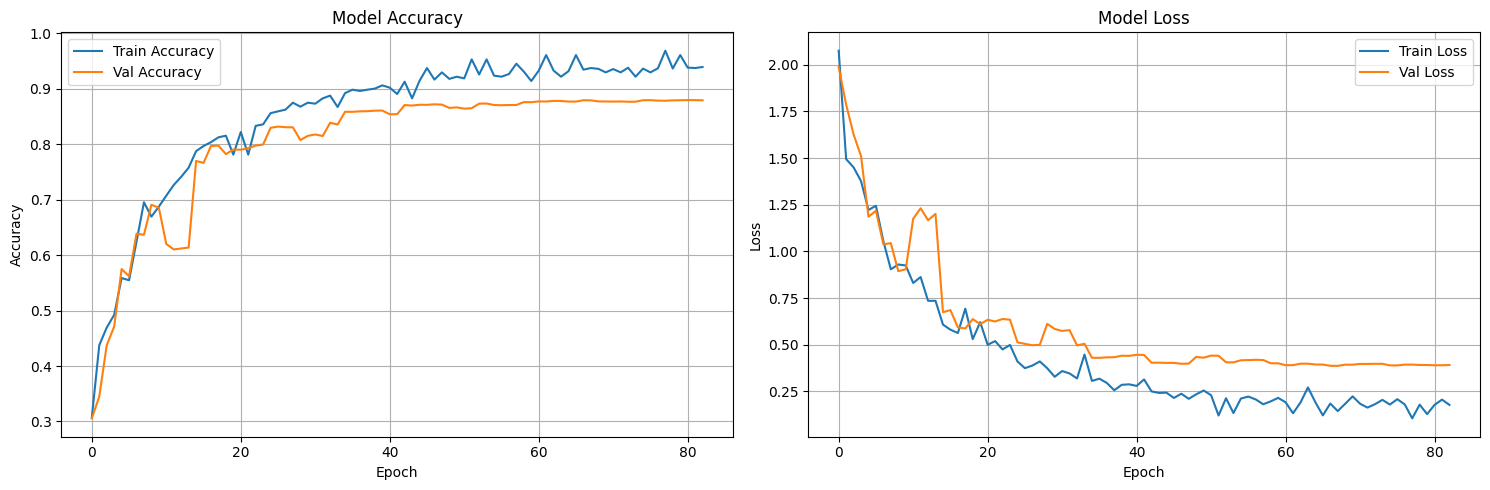

In [10]:
# Plot training history
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_history(history)

# Block 11: Model Evaluation


In [11]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8807 - loss: 0.3836

Test Loss: 0.3868
Test Accuracy: 0.8792 (87.92%)
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


# Block 12: Confusion Matrix & Classification Report


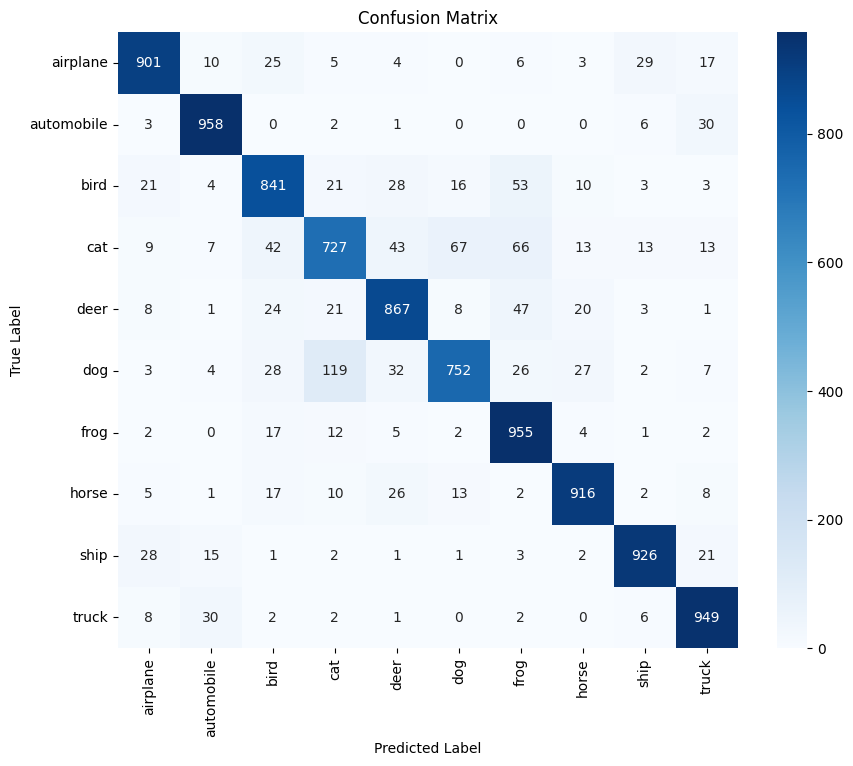


Classification Report:
              precision    recall  f1-score   support

    airplane       0.91      0.90      0.91      1000
  automobile       0.93      0.96      0.94      1000
        bird       0.84      0.84      0.84      1000
         cat       0.79      0.73      0.76      1000
        deer       0.86      0.87      0.86      1000
         dog       0.88      0.75      0.81      1000
        frog       0.82      0.95      0.88      1000
       horse       0.92      0.92      0.92      1000
        ship       0.93      0.93      0.93      1000
       truck       0.90      0.95      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Block 13: Visualize Predictions


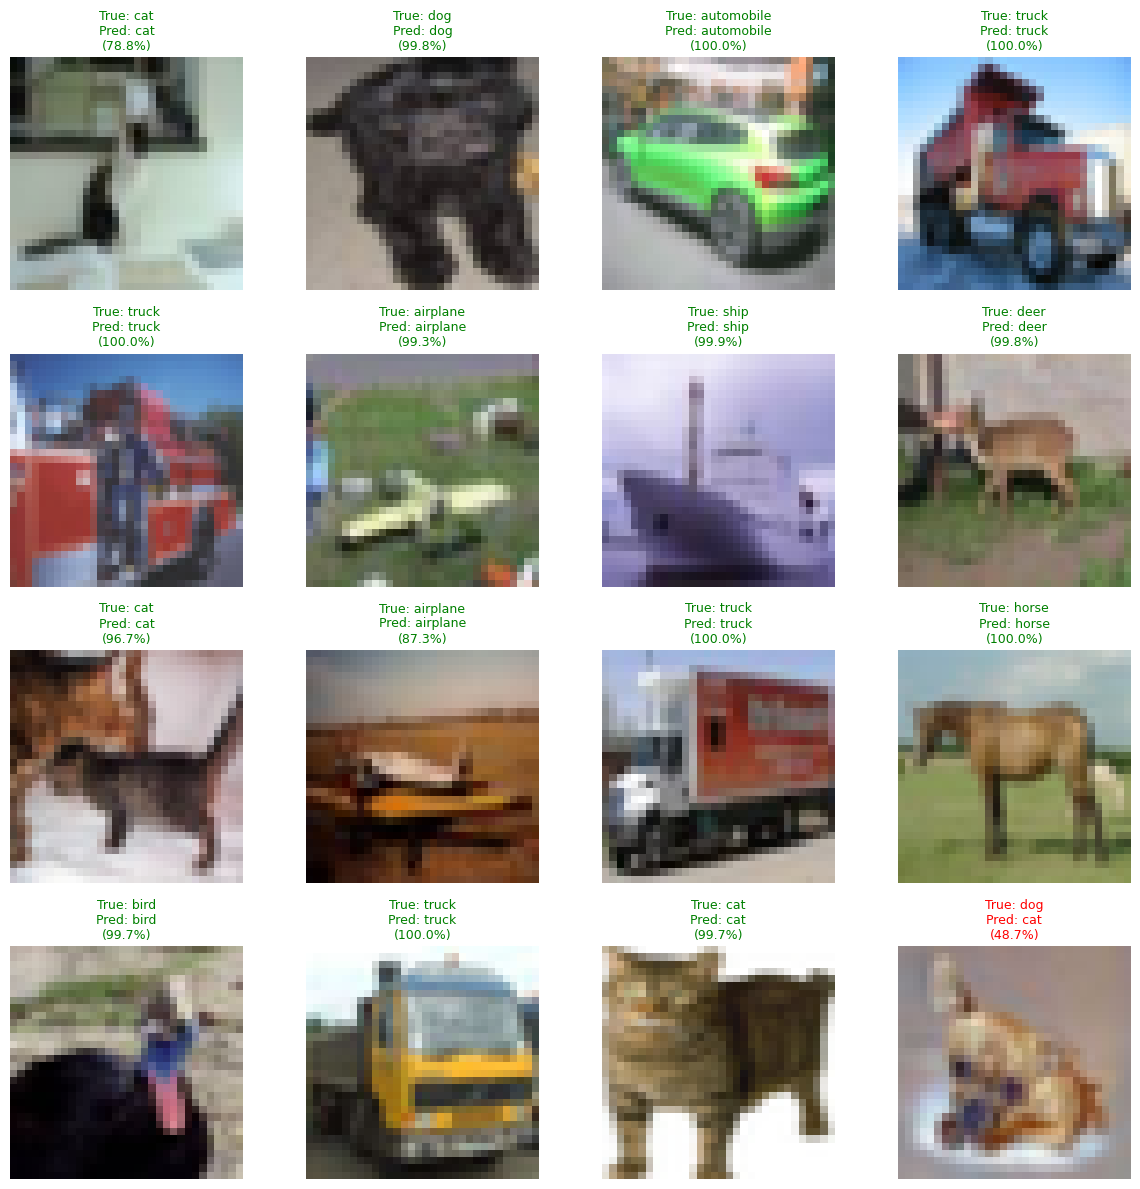

In [13]:
# Visualize some predictions
def visualize_predictions(num_images=16):
    indices = np.random.choice(len(x_test), num_images, replace=False)
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        axes[i].imshow(x_test[idx])
        true_label = class_names[true_classes[idx]]
        pred_label = class_names[predicted_classes[idx]]
        confidence = predictions[idx][predicted_classes[idx]] * 100
        
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)', 
                         color=color, fontsize=9)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions_sample.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions()

# Block 14: Save Final Model


In [14]:
# Save the complete model in native Keras format (recommended)
model.save('./models/resnet18_cifar10_final.keras')
print("Final model saved!")

# Save only weights (for loading into the same architecture later)
model.save_weights('./models/resnet18.weights.h5')
print("Model weights saved!")

print("\nModel files created:")
print("  - resnet18_cifar10_final.keras (complete model)")
print("  - resnet18.weights.h5 (weights only)")

Final model saved!
Model weights saved!

Model files created:
  - resnet18_cifar10_final.keras (complete model)
  - resnet18.weights.h5 (weights only)


# Block 15: Per-Class Accuracy Analysis


In [15]:
# Calculate per-class accuracy
from collections import defaultdict

class_correct = defaultdict(int)
class_total = defaultdict(int)

for i in range(len(true_classes)):
    label = true_classes[i]
    class_total[label] += 1
    if predicted_classes[i] == label:
        class_correct[label] += 1

# Print per-class accuracy
print("\nPer-Class Accuracy:")
print("-" * 40)
for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f"{class_names[i]:12s}: {accuracy:6.2f}% ({class_correct[i]}/{class_total[i]})")


Per-Class Accuracy:
----------------------------------------
airplane    :  90.10% (901/1000)
automobile  :  95.80% (958/1000)
bird        :  84.10% (841/1000)
cat         :  72.70% (727/1000)
deer        :  86.70% (867/1000)
dog         :  75.20% (752/1000)
frog        :  95.50% (955/1000)
horse       :  91.60% (916/1000)
ship        :  92.60% (926/1000)
truck       :  94.90% (949/1000)
